In [1]:
import numpy as np
import pandas as pd
from urllib.parse import urlparse
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df = pd.read_csv('test_dataset.csv')

In [3]:
def use_of_ip(url):
    ipv4_pattern = r'(\d{1,3}\.){3}\d{1,3}'
    ipv6_pattern = r'([a-fA-F0-9:]+:+)+[a-fA-F0-9]+'
    return 1 if re.search(ipv4_pattern, url) or re.search(ipv6_pattern, url) else 0

def abnormal_url(url):
    try:
        parsed_url = urlparse(url)
        hostname = parsed_url.hostname
        if not hostname:
            return 1
        return 0 if hostname in url and url.index(hostname) == url.find(parsed_url.netloc) else 1
    except:
        return 1

def count_character(url, char):
    return url.count(char)

def domain_length(url):
    return len(urlparse(url).netloc)

def short_url(url):
    return 1 if len(url) < 20 else 0

def no_of_embed(url):
    return urlparse(url).path.count('//')

def count_https(url):
    return url.count('https')

def count_http(url):
    return url.count('http')

def suspicious_words(url):
    return 1 if re.search(
        "account|alert|api|auth|bank|bonus|cmd|confirm|credit|dashboard|discount|download|exe|fake|"
        "free|gift|hacked|important|invoice|key|limited|login|malware|money|offer|password|pay|payment|"
        "paypal|prize|promo|recovery|redeem|refund|register|reset|reward|root|secure|setup|signin|shell|"
        "special|support|token|update|urgent|verify|warning|winner", url) else 0

def fd_length(url):
    urlpath = urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

def legitimate_extensions(url):
    # List of legitimate TLDs
    legitimate_tlds = (
        ".com|.org|.net|.info|.biz|.name|.pro|.edu|.gov|.mil|.us|.uk|.ca|.au|"
        ".in|.de|.fr|.jp|.cn|.ru|.br|.za|.nz|.mx|.sg|.tech|.app|.io|.ai|.dev|"
        ".online|.store|.blog|.design|.law|.health|.hotel|.travel|.bank|"
        ".finance|.insurance|.media|.agency|.realty|.arpa|.pharmacy|.tv|.me|.cc"
    )

    # Use regex to search for the legitimate TLDs in the URL
    return 0 if re.search(r'\b(' + legitimate_tlds + r')\b', url, re.IGNORECASE) else 1      

def extract_features(df):
    df['use_of_ip'] = df['url'].apply(use_of_ip)
    df['abnormal_url'] = df['url'].apply(abnormal_url)
    df['count.'] = df['url'].apply(lambda x: count_character(x, '.'))
    df['count-www'] = df['url'].apply(lambda x: count_character(x, 'www'))
    df['count@'] = df['url'].apply(lambda x: count_character(x, '@'))
    df['count-dir'] = df['url'].apply(lambda x: count_character(x, '/'))
    df['short_url'] = df['url'].apply(short_url)
    df['url_length'] = df['url'].apply(len)
    df['hostname_length'] = df['url'].apply(domain_length)
    df['count-'] = df['url'].apply(lambda x: count_character(x, '-'))
    df['count='] = df['url'].apply(lambda x: count_character(x, '='))
    df['count?'] = df['url'].apply(lambda x: count_character(x, '?'))
    df['count%'] = df['url'].apply(lambda x: count_character(x, '%'))
    df['count-digits'] = df['url'].apply(lambda x: sum(c.isdigit() for c in x))
    df['count-letters'] = df['url'].apply(lambda x: sum(c.isalpha() for c in x))
    df['count_embed_domian'] = df['url'].apply(no_of_embed)
    df['count-https'] = df['url'].apply(count_https)
    df['count-http'] = df['url'].apply(count_http)
    df['sus_url'] = df['url'].apply(suspicious_words)
    df['fd_length'] = df['url'].apply(fd_length)
    df['legitimate_extensions'] = df['url'].apply(legitimate_extensions)
    
    # Only process 'type' during training
    if 'type' in df.columns:
        from sklearn.preprocessing import LabelEncoder
        lb_make = LabelEncoder()
        df["url_type"] = lb_make.fit_transform(df["type"])
    
    return df


df = extract_features(df)

df.head()

,url,type,use_of_ip,abnormal_url,count.,count-www,count@,count-dir,short_url,url_length,...,count%,count-digits,count-letters,count_embed_domian,count-https,count-http,sus_url,fd_length,legitimate_extensions,url_type
0,br-icloud.com.br,phishing,0,1,2,0,0,0,1,16,...,0,0,13,0,0,0,0,0,0,3
1,mp3raid.com/music/krizz_kaliko.html,benign,0,1,2,0,0,2,0,35,...,0,1,29,0,0,0,0,5,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,1,2,0,0,3,0,31,...,0,1,25,0,0,0,0,7,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,0,3,1,0,3,0,88,...,0,7,63,0,0,1,0,9,1,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,0,2,0,0,3,0,235,...,0,22,199,0,0,1,0,9,0,1


In [4]:
# Model Training
x = df[['use_of_ip', 'abnormal_url', 'count.', 'count-www', 'count@',
        'count-dir', 'count_embed_domian', 'short_url', 'count-https',
        'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
        'hostname_length', 'sus_url', 'fd_length', 'count-digits',
        'count-letters','legitimate_extensions']]
y = df['url_type']

# Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Training Logistic Regression...
Logistic Regression - Accuracy: 0.9055555555555556, Precision: 0.7279239766081871, Recall: 0.6268562030075189, F1-Score: 0.6513859275053304
Confusion Matrix for Logistic Regression:
[[129   3   0   1]
 [  1  30   1   0]
 [  0   2   2   1]
 [  5   3   0   2]]


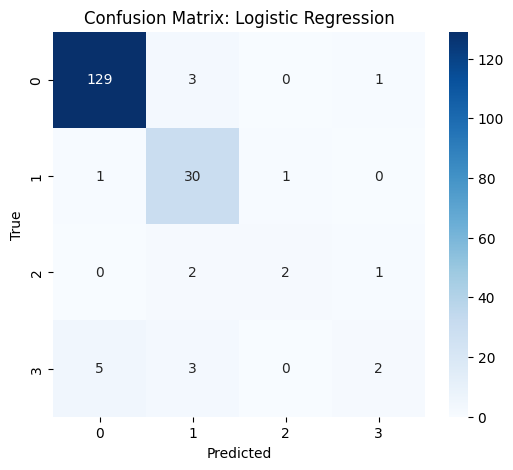

Training Decision Tree...
Decision Tree - Accuracy: 0.9333333333333333, Precision: 0.7599206349206349, Recall: 0.7999765037593984, F1-Score: 0.7750094895792558
Confusion Matrix for Decision Tree:
[[128   3   2   0]
 [  0  30   1   1]
 [  0   1   3   1]
 [  0   2   1   7]]


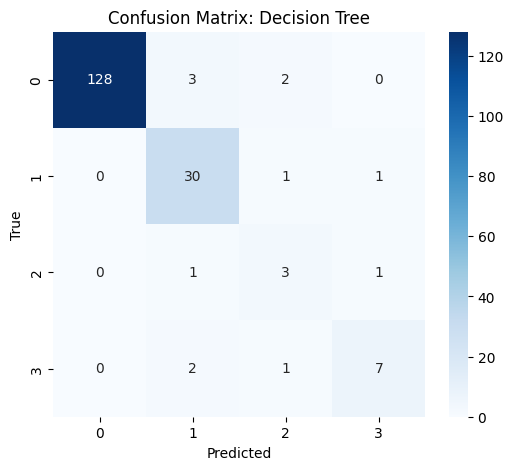

Training Random Forest...
Random Forest - Accuracy: 0.9666666666666667, Precision: 0.9349662162162162, Recall: 0.7749999999999999, F1-Score: 0.8191856452726018
Confusion Matrix for Random Forest:
[[133   0   0   0]
 [  0  32   0   0]
 [  0   2   2   1]
 [  0   3   0   7]]


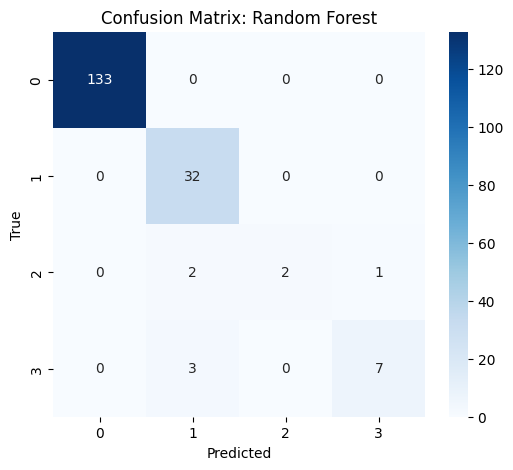

Training Gradient Boosting...
Gradient Boosting - Accuracy: 0.9611111111111111, Precision: 0.9321621061359867, Recall: 0.7671874999999999, F1-Score: 0.8143064341841606
Confusion Matrix for Gradient Boosting:
[[133   0   0   0]
 [  1  31   0   0]
 [  0   2   2   1]
 [  0   3   0   7]]


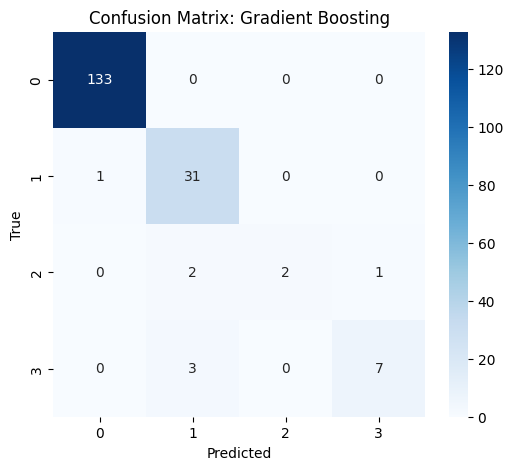

Training Naive Bayes...
Naive Bayes - Accuracy: 0.8444444444444444, Precision: 0.4913733609385783, Recall: 0.5718045112781954, F1-Score: 0.5238365238365238
Confusion Matrix for Naive Bayes:
[[118   9   4   2]
 [  0  32   0   0]
 [  1   2   2   0]
 [  7   3   0   0]]


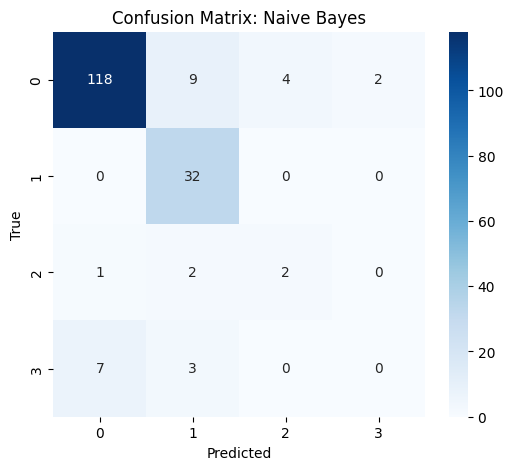

Training Support Vector Machine...
Support Vector Machine - Accuracy: 0.9055555555555556, Precision: 0.6879120879120879, Recall: 0.5746828007518797, F1-Score: 0.5984054880875127
Confusion Matrix for Support Vector Machine:
[[132   1   0   0]
 [  3  29   0   0]
 [  1   2   2   0]
 [  7   3   0   0]]


C:\Users\vicky\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


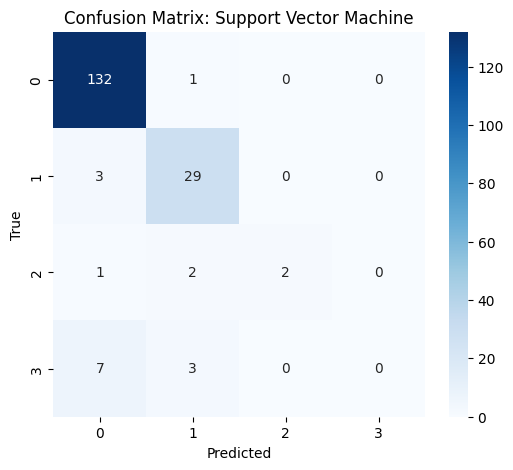

Training K-Nearest Neighbors...
K-Nearest Neighbors - Accuracy: 0.9111111111111111, Precision: 0.8757099490795143, Recall: 0.6537359022556392, F1-Score: 0.6693649149930234
Confusion Matrix for K-Nearest Neighbors:
[[130   3   0   0]
 [  1  30   1   0]
 [  1   1   3   0]
 [  6   3   0   1]]


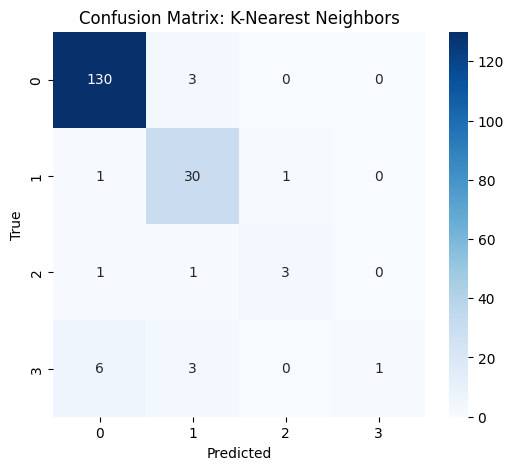

Training XGBoost...


C:\Users\vicky\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [18:59:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Accuracy: 0.9555555555555556, Precision: 0.9263297602113392, Recall: 0.7653078007518797, F1-Score: 0.8100595692128872
Confusion Matrix for XGBoost:
[[132   1   0   0]
 [  1  31   0   0]
 [  0   2   2   1]
 [  0   3   0   7]]


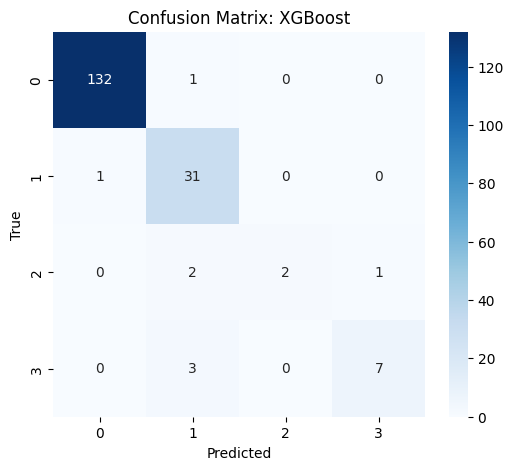

Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 364
[LightGBM] [Info] Number of data points in the train set: 719, number of used features: 17
[LightGBM] [Info] Start training from score -0.314463
[LightGBM] [Info] Start training from score -1.710327
[LightGBM] [Info] Start training from score -3.399808
[LightGBM] [Info] Start training from score -2.888982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

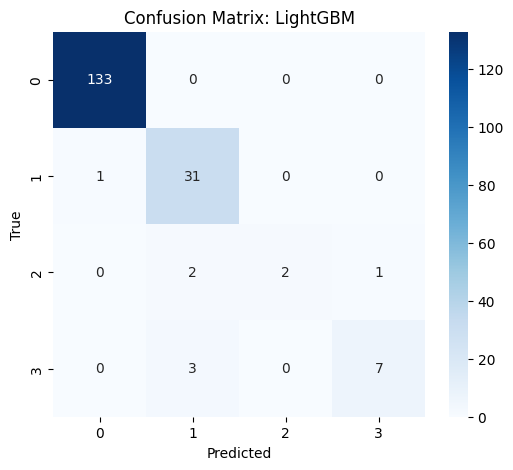


Model Performance Summary:
Logistic Regression: {'Accuracy': 0.9055555555555556, 'Precision': 0.7279239766081871, 'Recall': 0.6268562030075189, 'F1-Score': 0.6513859275053304}
Decision Tree: {'Accuracy': 0.9333333333333333, 'Precision': 0.7599206349206349, 'Recall': 0.7999765037593984, 'F1-Score': 0.7750094895792558}
Random Forest: {'Accuracy': 0.9666666666666667, 'Precision': 0.9349662162162162, 'Recall': 0.7749999999999999, 'F1-Score': 0.8191856452726018}
Gradient Boosting: {'Accuracy': 0.9611111111111111, 'Precision': 0.9321621061359867, 'Recall': 0.7671874999999999, 'F1-Score': 0.8143064341841606}
Naive Bayes: {'Accuracy': 0.8444444444444444, 'Precision': 0.4913733609385783, 'Recall': 0.5718045112781954, 'F1-Score': 0.5238365238365238}
Support Vector Machine: {'Accuracy': 0.9055555555555556, 'Precision': 0.6879120879120879, 'Recall': 0.5746828007518797, 'F1-Score': 0.5984054880875127}
K-Nearest Neighbors: {'Accuracy': 0.9111111111111111, 'Precision': 0.8757099490795143, 'Recall': 

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

results = {}
# Helper function to train, evaluate, and display the confusion matrix
def train_and_evaluate_with_confusion_matrix(model, model_name):
    
    print(f"Training {model_name}...")
    model.fit(x_train, y_train)  # Train the model
    y_pred = model.predict(x_test)  # Predict on the test set

    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    results[model_name] = {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-Score": f1}

    # Print evaluation metrics
    print(f"{model_name} - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}")

    if model_name == 'Random Forest' or 'LightGBM':
        # Generate and display confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        print(f"Confusion Matrix for {model_name}:\n{cm}")
    
        # Visualize confusion matrix with Seaborn heatmap
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
        plt.title(f"Confusion Matrix: {model_name}")
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
    else:
        pass    

# Train and evaluate models
models = {
    "Logistic Regression": LogisticRegression(max_iter=100000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Naive Bayes": MultinomialNB(),
    "Support Vector Machine": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier()
}
# Train and evaluate all models with confusion matrices
for model_name, model in models.items():
    train_and_evaluate_with_confusion_matrix(model, model_name)

# Display all results
print("\nModel Performance Summary:")
for model_name, metrics in results.items():
    print(f"{model_name}: {metrics}")
